# Trabalho Prático 1 - Aprendizado de Máquina
<font size=4>Nome: Alexandre Maros<br></font>
<font size=3>UFMG - 2018/1</font>


Blabla...

In [79]:
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os

pd.options.display.max_rows = 10

# 1. Leitura dos Dados

In [3]:
# Encontrar Diretorio Atual
diretorio_atual = os.path.realpath('.')

# Ler o arquivo de entrada
dados = pd.read_csv(os.path.join(diretorio_atual, "data_tp1"), sep=",", header=None)

# Armazenar o label correto dos numeros
dados = dados.rename(columns = {0:'label'})
y = dados.label

# Retirar a primeira coluna referente aos labels
X = dados.drop("label", axis=1)

# Modificar o nome das colunas
num_imagens = X.shape[1]
X.columns = [ int(x) for x in range(0, num_imagens)] 

X

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Visualização dos dados

Nesta etapa...

### Visualização dos três primeiro dígitos do dataset

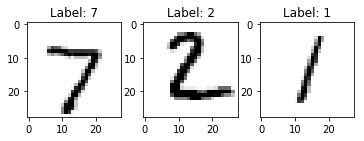

In [5]:
digitos = [ X.loc[0,:], X.loc[1,:], X.loc[2,:] ]
labels = [ y[0], y[1], y[2] ]

# 784 colunas correspondem a uma imagem de 28x28
plot1 = np.reshape(digitos[0].values, (28, 28))
plot2 = np.reshape(digitos[1].values, (28, 28))
plot3 = np.reshape(digitos[2].values, (28, 28))

fig=plt.figure(figsize=(8, 8))

# Plot the digits
fig.add_subplot(4, 4, 1)
plt.imshow(plot1, cmap='gray_r')
plt.title('Label: {}'.format(labels[0]))

fig.add_subplot(4, 4, 2)
plt.imshow(plot2, cmap='gray_r')
plt.title('Label: {}'.format(labels[1]))

fig.add_subplot(4, 4, 3)
plt.imshow(plot3, cmap='gray_r')
plt.title('Label: {}'.format(labels[2]))

plt.show()


### Verificando a distribuição dos dígitos

É interessante verificar a disposição (frequência) dos dígitos no dataset. Se tiver muitos digitos 1 e poucos dígitos 9 isso pode levar a uma má previsão.

In [9]:
y.value_counts(normalize=True).sort_index()

0    0.0920
1    0.1142
2    0.1060
3    0.1000
4    0.1000
5    0.0912
6    0.0924
7    0.1024
8    0.0978
9    0.1040
Name: label, dtype: float64

Os dígitos parecem estar bem distribuídos, sendo que os dígitos 0 e 5 são os dois digitos que menos aparecem (9.2% dos dígitos são o dígito 0 e 0.912% dos digitos são o dígito 5). O dígito 1 é o que mais aparece, com sua frequência em 11%.

# 3. Construção dos Modelos

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
scaler.fit(X_train)
StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [104]:
# Variaveis
# batch_size, early_stopping(?), hidden_layer_sizes, learning_rate_init, max_iter (num epochs),
#   momentum(and nesterov_momentum?), validation_fraction (if early_stopping=True)
clf = MLPClassifier(solver='sgd', batch_size='auto', early_stopping=False, hidden_layer_sizes=(100,),
                    learning_rate_init=0.01, max_iter=400, momentum=0.1, shuffle=True, verbose=False)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=400, momentum=0.1,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [103]:
#clf.predict_proba(X.loc[1,:].values.reshape(1, -1))
predictions = clf.predict_proba(X_test)

log_loss(y_test, predictions)

0.45119266970813177